In [1]:
import pandas as pd
from pathlib import Path

path = Path("CTA_-_Ridership_-_Daily_Boarding_Totals_20240803.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8583 entries, 0 to 8582
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   service_date    8583 non-null   datetime64[ns]
 1   day_type        8583 non-null   object        
 2   bus             8583 non-null   int64         
 3   rail_boardings  8583 non-null   int64         
 4   total_rides     8583 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 335.4+ KB


In [3]:
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [4]:
df.sample(2)

,day_type,bus,rail
date,,,
2003-12-29,W,732494,461979
2015-04-08,W,822289,750275


<Axes: xlabel='date'>

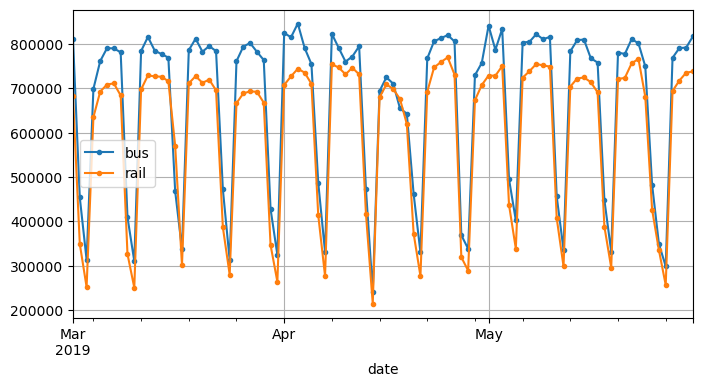

In [5]:
import matplotlib.pyplot as plt

df["2019-03" : "2019-05"].plot(grid=True, marker=".", figsize=(8, 4))

### fig 1 : 현재 값을 그대로 일주일만큼 shift
### fig 2 : 현재 - 일주일 전 차분

In [6]:
plt.rcParams['font.family'] = "batang"

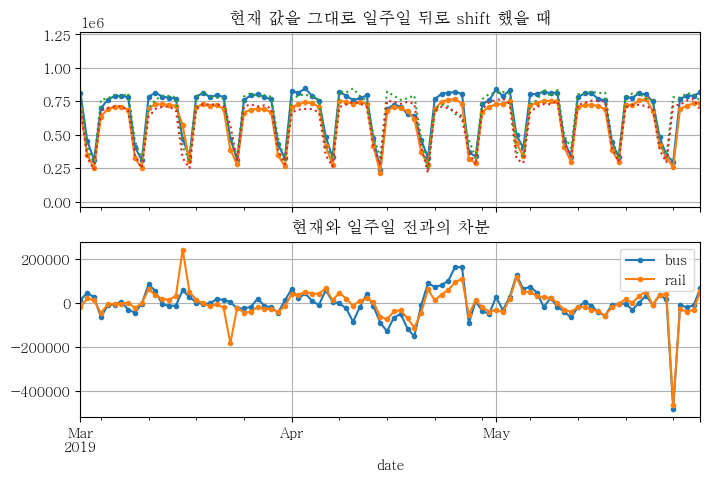

In [7]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03" : "2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

df.plot(ax=axs[0], legend=False, marker=".")
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
axs[0].set_title("현재 값을 그대로 일주일 뒤로 shift 했을 때")

diff_7.plot(ax=axs[1], grid=True, marker=".")
axs[1].set_title("현재와 일주일 전과의 차분")

plt.show()

In [8]:
list(df.loc["2019-05-25" : "2019-05-27"]["day_type"])

['A', 'U', 'U']

### MAE, MAPE

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [9]:
targets = df[["bus", "rail"]]["2019-03" : "2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

### 월단위 시각화 (+12개월 이평)

C:\Users\davidbowman\AppData\Local\Temp\ipykernel_2528\526479020.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[["bus", "rail"]].resample("M").mean()


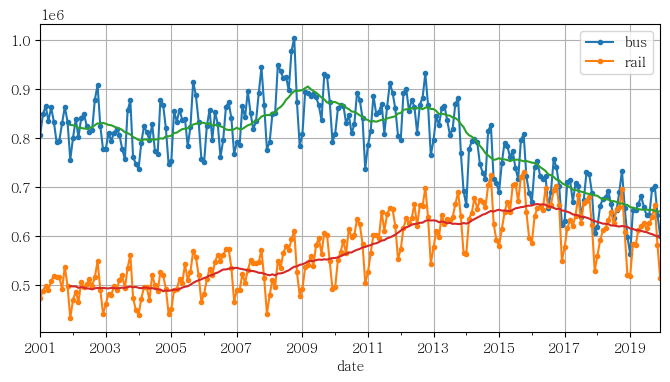

In [10]:
period = slice("2001", "2019")
df_monthly = df[["bus", "rail"]].resample("M").mean()

rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)

plt.show()

In [12]:
df[["bus", "rail"]].resample("ME")

In [11]:
rsmpl = pd.DataFrame(df[["bus", "rail"]].resample("ME"))
rsmpl.head()

,0,1
0,2001-01-31,bus rail date ...
1,2001-02-28,bus rail date ...
2,2001-03-31,bus rail date ...
3,2001-04-30,bus rail date ...
4,2001-05-31,bus rail date ...


In [14]:
rsmpl[1][0].__class__

pandas.core.frame.DataFrame

### 12개월 단위 차분 계산

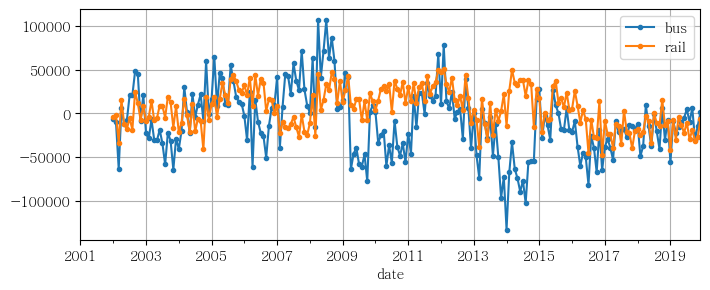

In [15]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

## 통계 모델로 예측해보기

In [16]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin : today]["rail"].asfreq("D")
model = ARIMA(
    rail_series, 
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 7)
)
model = model.fit()
y_pred = model.forecast()

In [17]:
y_pred

2019-06-01    427758.62632
Freq: D, dtype: float64

In [18]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin : end_date]["rail"].asfreq("D")
y_preds = []

for today in time_period.shift(-1):
    model = ARIMA(
        rail_series[origin : today],
        order=(1, 0, 0),
        seasonal_order=(0, 1, 1, 7)
    )
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

C:\Users\davidbowman\AppData\Local\Temp\ipykernel_2528\92308974.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\davidbowman\AppData\Local\Temp\ipykernel_2528\92308974.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\davidbowman\AppData\Local\Temp\ipykernel_2528\92308974.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0

In [19]:
mae

32040.720103056392

## 신경망 활용 ; 그 전에 데이터를 맞춰서 준비하기

### 목표 : 과거 8주(==56일) 데이터를 기반으로 내일 승객 예측하기

In [20]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series, # 윈도우화할 것 : 원본
    targets=my_series[3:], # 타깃
    sequence_length=3, # 윈도우 크기
    batch_size=2 # 미니배치 크기 : 미니배치 당 윈도우 수
        # 총 미니배치 수 : 윈도우 수 / 미니배치 수 ; 딱딱 안떨어지면 마지막은 남은 만큼만 갖고 미니배치 생성
)

In [21]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [22]:
# 비슷하게 tf.data.Dataset.window로 데이터셋 생성 가능

for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")

    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [23]:
# 미달분 ([3, 4, 5]같은 것들)은 drop_remainder=True로 설정해 제거 가능

for window_dataset in tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True):
    for element in window_dataset:
        print(f"{element}", end=" ")

    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 


In [41]:
dataset = tf.data.Dataset.range(6).window(3, shift=1, drop_remainder=True)
print(f"BEFORE: {[list(wd.as_numpy_iterator()) for wd in dataset]}")

dataset = dataset.flat_map(lambda wd: wd.batch(2))
print(f"AFTER: {list(dataset.as_numpy_iterator())}\n")

BEFORE: [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5]]
AFTER: [array([0, 1], dtype=int64), array([2], dtype=int64), array([1, 2], dtype=int64), array([3], dtype=int64), array([2, 3], dtype=int64), array([4], dtype=int64), array([3, 4], dtype=int64), array([5], dtype=int64)]



In [19]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset : window_dataset.batch(2))
list(dataset.as_numpy_iterator())

[array([0, 1], dtype=int64),
 array([2, 3], dtype=int64),
 array([1, 2], dtype=int64),
 array([3, 4], dtype=int64),
 array([2, 3], dtype=int64),
 array([4, 5], dtype=int64)]

In [20]:
# 모델은 입력으로 텐서를 받기 때문에
# 윈도우를 한번 더 처리해야 함
# -> 윈도우의 각 요소는 텐서가 아닌 데이터셋이기 때문에
# flat_map : 윈도우 각 요소(==개별 데이터셋)에 함수 적용 + 펼치기

dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset : window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [32]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds : window_ds.batch(length))

In [33]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window : (window[ : -1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

In [34]:
rail_train = df["rail"]["2016-01" : "2018-12"] / 1e6
rail_valid = df["rail"]["2019-01" : "2019-05"] / 1e6
rail_test = df["rail"]["2019-06" : ] / 1e6

In [35]:
seq_length = 56

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

### ~ 15.3.2, ~ 082124 WED 1700
### -> 15.3.2 ~ : 선형 모델로 예측하기부터

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)

history = model.fit(
    train_ds, validation_data=valid_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

In [ ]:
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_test.to_numpy(),
    targets=rail_test[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

In [ ]:
abs(model.predict(test_ds)).mean() * 1e6

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)

history = model.fit(
    train_ds, validation_data=valid_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((None, 1)),
    tf.keras.layers.SimpleRNN(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)

history = model.fit(
    train_ds, validation_data=valid_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((None, 1)),
    tf.keras.layers.SimpleRNN(1)
])

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)

history = model.fit(
    train_ds, validation_data=valid_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

In [ ]:
model.layers[0].get_weights()

In [ ]:
model.summary()

In [ ]:
model.get_weights()

In [ ]:
model.layers[0].input

In [ ]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

univar_model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)

history = univar_model.fit(
    train_ds, validation_data=valid_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

In [ ]:
abs(univar_model.predict(test_ds)).mean()

In [ ]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

deep_model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)

history = deep_model.fit(
    train_ds, validation_data=valid_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

In [42]:
df_mulvar = df[["bus", "rail"]] / 1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)

In [43]:
mulvar_train = df_mulvar["2016-01" : "2018-12"]
mulvar_valid = df_mulvar["2019-01" : "2019-05"]
mulvar_test = df_mulvar["2019-06" : ]

In [44]:
mulvar_train

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2016-01-01,0.303321,0.319835,1.0,0.0,0.0
2016-01-02,0.448859,0.365509,0.0,1.0,0.0
2016-01-03,0.340540,0.287661,0.0,0.0,1.0
2016-01-04,0.829429,0.703185,0.0,0.0,1.0
2016-01-05,0.846789,0.727716,0.0,0.0,1.0
...,...,...,...,...,...
2018-12-27,0.509948,0.453029,0.0,0.0,1.0
2018-12-28,0.577497,0.493961,1.0,0.0,0.0
2018-12-29,0.394088,0.307105,0.0,1.0,0.0


In [47]:
list(tf.data.Dataset.from_tensor_slices(mulvar_train.iloc[:10]))

[<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.303321, 0.319835, 1.      , 0.      , 0.      ])>,
 <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.448859, 0.365509, 0.      , 1.      , 0.      ])>,
 <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.34054 , 0.287661, 0.      , 0.      , 1.      ])>,
 <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.829429, 0.703185, 0.      , 0.      , 1.      ])>,
 <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.846789, 0.727716, 0.      , 0.      , 1.      ])>,
 <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.853904, 0.733167, 0.      , 0.      , 1.      ])>,
 <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.846274, 0.736809, 0.      , 0.      , 1.      ])>,
 <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.841494, 0.732495, 1.      , 0.      , 0.      ])>,
 <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.469539, 0.391597, 0.      , 1.      , 0.      ])>,
 <tf.Tensor: shape=(5,), dtype=float64, numpy=

In [38]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

In [ ]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

mulvar_model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)

history = mulvar_model.fit(
    train_mulvar_ds, validation_data=valid_mulvar_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

In [ ]:
train_mulres_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulres_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

In [ ]:
mulres_model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(2)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

mulres_model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)

history = mulres_model.fit(
    train_mulres_ds, validation_data=valid_mulres_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

In [43]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, : seq_length, np.newaxis]

for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

NameError: name 'univar_model' is not defined

In [39]:
def split_inputs_and_targeets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length+14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targeets)

ahead_valid_ds  = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length+14,
    batch_size=32
).map(split_inputs_and_targeets)

In [40]:
ahead_train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

In [41]:
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

C:\Users\davidbowman\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
np.arange(seq_length, df['rail']["2019-02" : "2019-03"].shape[0])

array([56, 57, 58])

In [45]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
Y_pred = ahead_model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


In [46]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)

list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

In [57]:
# 1. 데이터를 [[t0, t1, t2], [t1, t2, t3], [t2, t3, t4], ...] 식으로 윈도우화 -> ds.window
#     -> return : Dataset of Window Dataset
# *** ti -> [버스 탑승량, 철도 교통량, 범주 1, 범주 2, 범주 3]
#     -> [WD(t0, t1, t2), ... ]

# 2. 다음을 실시
# 2.1 주어진 length 만큼 윈도우 데이터셋 내의 텐서들을 묶어 (length * features) 모양의 텐서 데이터셋 생성 : win_ds.batch(length)
#     -> return : Dataset of Tensor
#     (if length : 2) : [t0, t1, t2] -> [Tensor(t0, t1), Tensor(t1, t2)] / [t1, t2, t3] -> [Tensor(t1, t2), Tensor(t2, t3)] / ...
#     DS[WDS[Tensor(t0, t1), Tensor(t1, t2)], WDS[Tensor(t1, t2), Tensor(t2, t3)], ...]
# 2.2 flat : ~ ndarray ravel
#    -> return : Dataset of Tensor(shape: (length * features), vals: (ti, ti+1))
#    -> DS[Tensor(t0, t1), Tensor(t1, t2), Tensor(t1, t2), Tensor(t2, t3), ...]


def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds : window_ds.batch(length))

In [63]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

In [64]:
def to_seq2seq_dataset(
    series,
    seq_length=56,
    ahead=14,
    target_col=1,
    batch_size=32,
    shuffle=False,
    seed=None
):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead+1)
    ds = to_windows(ds, seq_length)
    ds = ds.map(lambda S: (S[:, 0], S[:, 1:, 1]))

    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    
    return ds.batch(batch_size)

In [65]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [66]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.Input((None, 5)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

seq2seq_model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)

history = seq2seq_model.fit(
    seq2seq_train, validation_data=seq2seq_valid,
    epochs=500,
    callbacks=[early_stopping_cb]
)

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred14 = seq2seq_model.predict(X)[0, -1]

In [ ]:
y_pred14

## 15.4 긴 시퀀스 다루기

In [5]:
import numpy as np

In [6]:
d = [29, 78, 82, 87, 89, 57]

print(*[sum(d[i : i+4])/4 for i in range(3)])
print(*[np.std(d[i : i+4]) for i in range(3)])

69.0 84.0 78.75
23.313086453749534 4.301162633521313 12.813567028739499


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [50]:
import seaborn as sns

<Axes: >

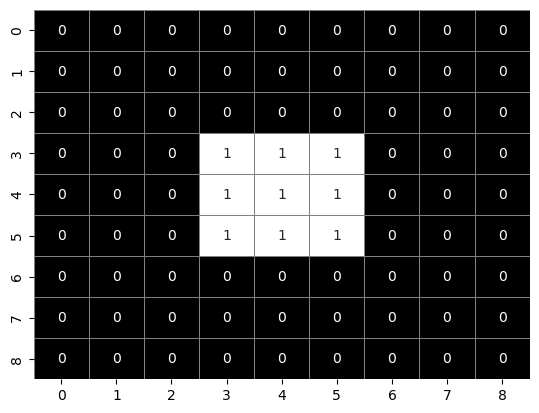

In [67]:
image = np.zeros((9, 9))
image[3:6, 3:6] = 1

sns.heatmap(image, cmap="gray", cbar=False, linewidths=0.5, linecolor="gray", annot=True)

In [39]:
dilation_tst_model = tf.keras.Sequential()
#dilation_tst_model.add(tf.keras.Input(shape=[None, 1]))
dilation_tst_model.add(tf.keras.layers.Conv2D(
    filters=1, kernel_size=3, padding="same", dilation_rate=2
))

In [ ]:
reshaped = dilation_tst_model(image[np.newaxis, : , : , np.newaxis])

<Axes: >

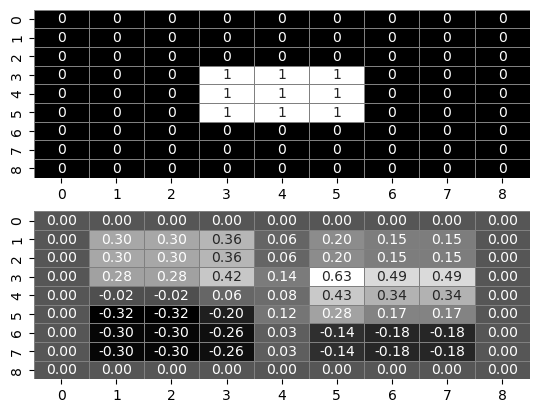

In [70]:
fig, axes = plt.subplots(2)

sns.heatmap(
    image,
    cmap="gray", cbar=False,
    linewidths=0.5,
    linecolor="gray", 
    annot=True,
    ax=axes[0]
)

sns.heatmap(
    reshaped.numpy().reshape(9, 9),
    cmap="gray", cbar=False,
    linewidths=0.5, linecolor="gray",
    annot=True, fmt=".2f",
    ax=axes[1]
)